In [1]:
# GET THE DATAFRAME.

import pandas as pd

df_path = "../../data/raw/debunking_review.tsv"
df = pd.read_csv(df_path, sep="\t")

In [2]:
# PERFORM DATA PROCESSING (LEMATIZATION ETC), GET TFIDF SCORES AND FEATURE NAMES.

from eppi_text_classification import (
    get_features_and_labels,
    get_tfidf_and_names,
)

word_features, labels = get_features_and_labels(df)

tfidf_scores, feature_names = get_tfidf_and_names(word_features)

In [3]:
# PERFORM AN OPTUNA HYPERPARAMETER SEARCH, CAN CHANGE THE SEARCH SPACE IN OPT.PY

from eppi_text_classification import OptunaHyperparameterOptimisation

optimiser = OptunaHyperparameterOptimisation(
    tfidf_scores,
    labels,
    "LGBMClassifier",
    n_trials_per_job=10,
    n_jobs=-1,
    nfolds=3,
    num_cv_repeats=1,
    # db_url=f"sqlite:////mnt/tmp/optuna.db", #Use this one on Azure
    db_url=None,
)

optimiser.delete_optuna_study("lgbm_binary")
best_params = optimiser.optimise_hyperparameters(study_name="lgbm_binary")

[I 2024-08-07 19:08:12,570] A new study created in RDB with name: lgbm_binary
[I 2024-08-07 19:08:22,865] Trial 9 finished with value: 0.589894695859262 and parameters: {'max_depth': 14, 'min_child_samples': 7, 'learning_rate': 0.4257400479208754, 'num_leaves': 11, 'n_estimators': 236, 'min_split_gain': 8.365958885289504e-05, 'min_child_weight': 3.112230644402187e-05, 'reg_alpha': 0.00709767294635503, 'reg_lambda': 0.0328255950244877}. Best is trial 9 with value: 0.589894695859262.
[I 2024-08-07 19:08:23,807] Trial 2 finished with value: 0.9215902437698693 and parameters: {'max_depth': 6, 'min_child_samples': 5, 'learning_rate': 0.16021771929521098, 'num_leaves': 33, 'n_estimators': 160, 'min_split_gain': 0.010875136619970412, 'min_child_weight': 2.7492409789282635e-06, 'reg_alpha': 0.9706671866705068, 'reg_lambda': 0.0005973489800585066}. Best is trial 2 with value: 0.9215902437698693.
[I 2024-08-07 19:08:23,920] Trial 3 finished with value: 0.620352518372394 and parameters: {'max_dep

In [4]:
# FIT THE MODEL

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

# model = LGBMClassifier(**best_params)

model = LGBMClassifier(
    verbosity=-1,
    boosting_type="gbdt",
    max_depth=4,
    min_child_samples=30,
    learning_rate=0.1245928917280467,
    num_leaves=6,
    n_estimators=2455,
    subsample_for_bin=20000,
    subsample=1.0,
    objective="binary",
    scale_pos_weight=27,
    min_split_gain=2.52381000405986e-06,
    min_child_weight=5.544840854157574e-06,
    reg_alpha=3.629909607712911e-05,
    reg_lambda=3.671749546766942e-05,
)

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_scores, labels, test_size=0.333, stratify=labels, random_state=8
)

model.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.1245928917280467, max_depth=4,
               min_child_samples=30, min_child_weight=5.544840854157574e-06,
               min_split_gain=2.52381000405986e-06, n_estimators=2455,
               num_leaves=6, objective='binary',
               reg_alpha=3.629909607712911e-05,
               reg_lambda=3.671749546766942e-05, scale_pos_weight=27,
               subsample_for_bin=20000, verbosity=-1)

In [5]:
# CREATE ROC CURVE TO SELECT THRESHOLD

from eppi_text_classification.predict import predict_scores
from eppi_text_classification.plotly_roc import plotly_roc

y_test_pred_probs = predict_scores(model, X_test)
plotly_roc(y_test, y_test_pred_probs)

In [6]:
# GET MODEL THRESHOLD FOR CHOSEN TPR, MAKE PREDICTIONS

from eppi_text_classification.predict import (
    get_raw_threshold,
    raw_threshold_predict,
)

threshold = get_raw_threshold(model, X_test, y_test, target_tpr=1)

y_test_pred = raw_threshold_predict(model, X_test, threshold)
y_train_pred = raw_threshold_predict(model, X_train, threshold)

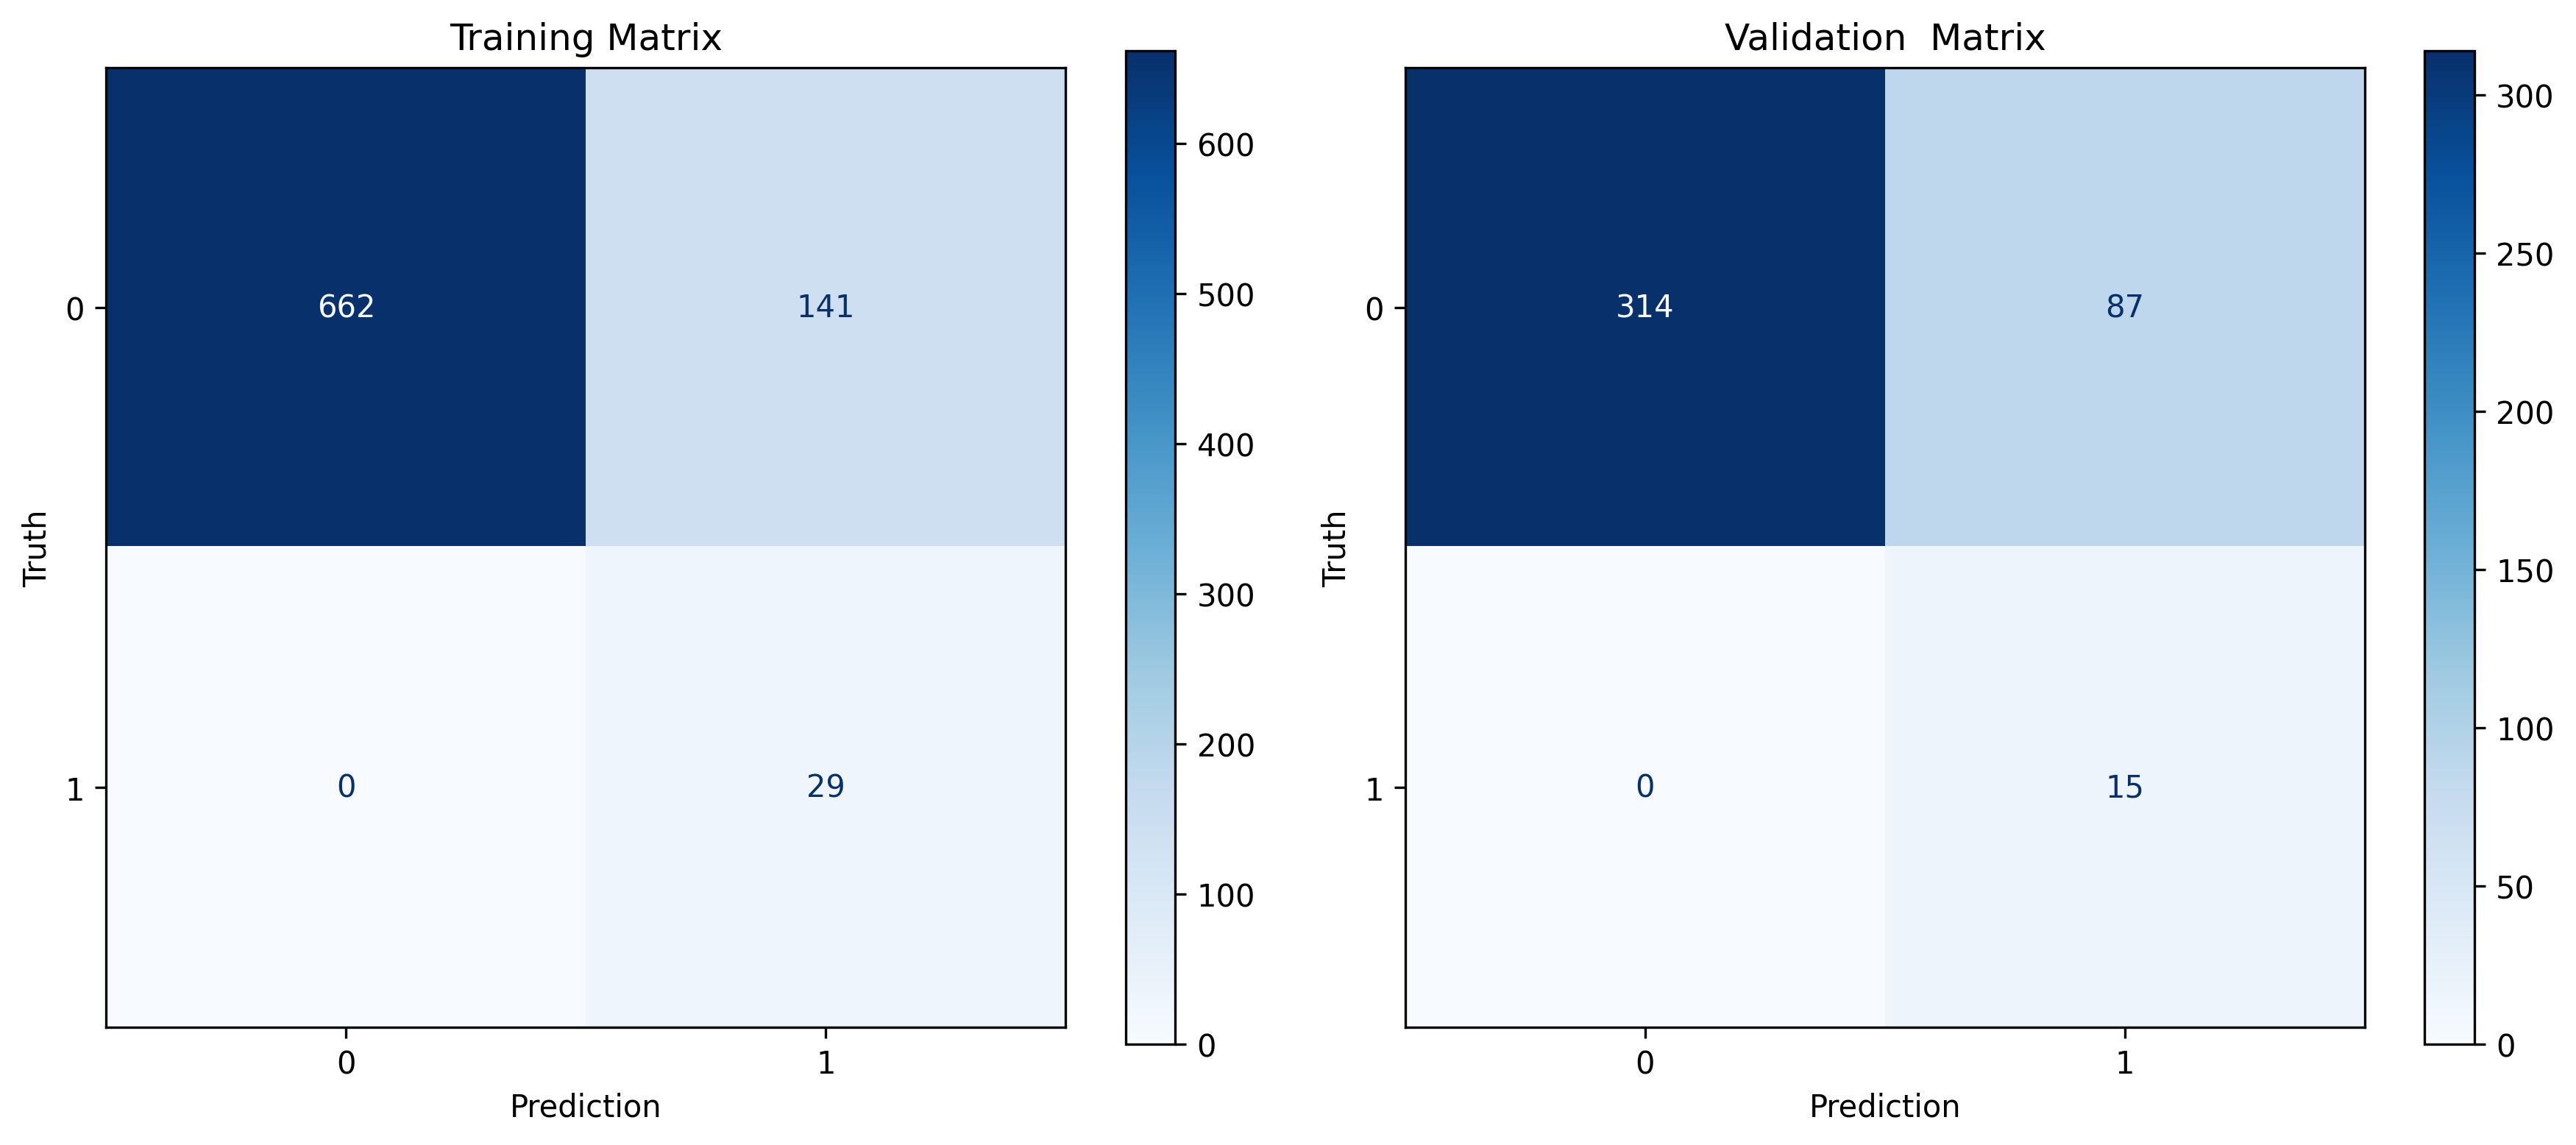

In [7]:
from eppi_text_classification.plots import binary_train_valid_confusion_plot

binary_train_valid_confusion_plot(
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
)

In [8]:
from eppi_text_classification import binary_train_valid_confusion_plotly

binary_train_valid_confusion_plotly(
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
    postive_label="Included",
    negative_label="Excluded",
)

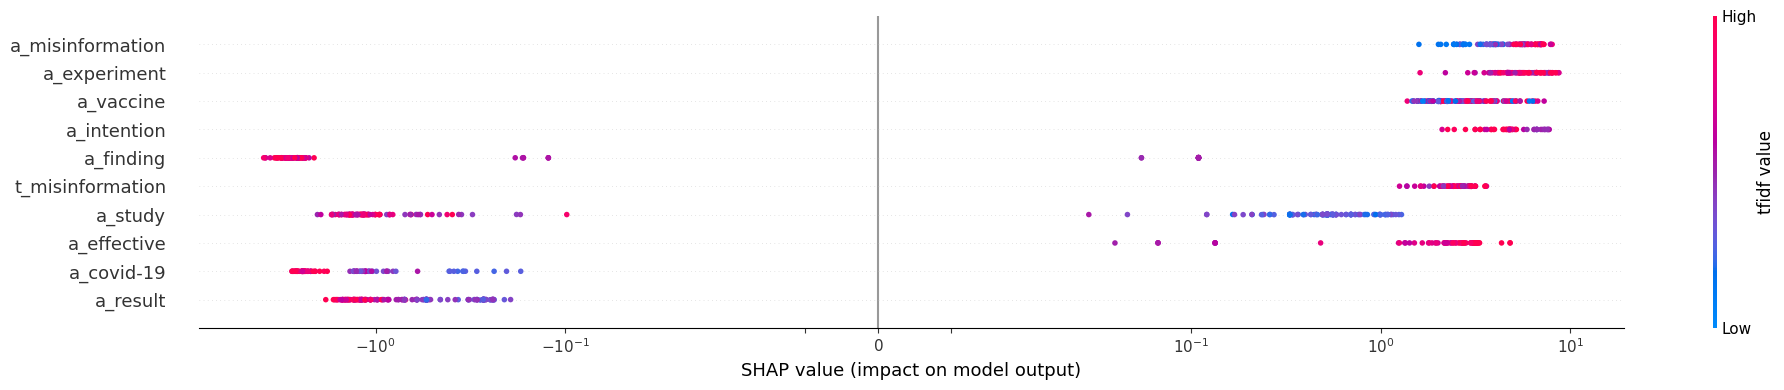

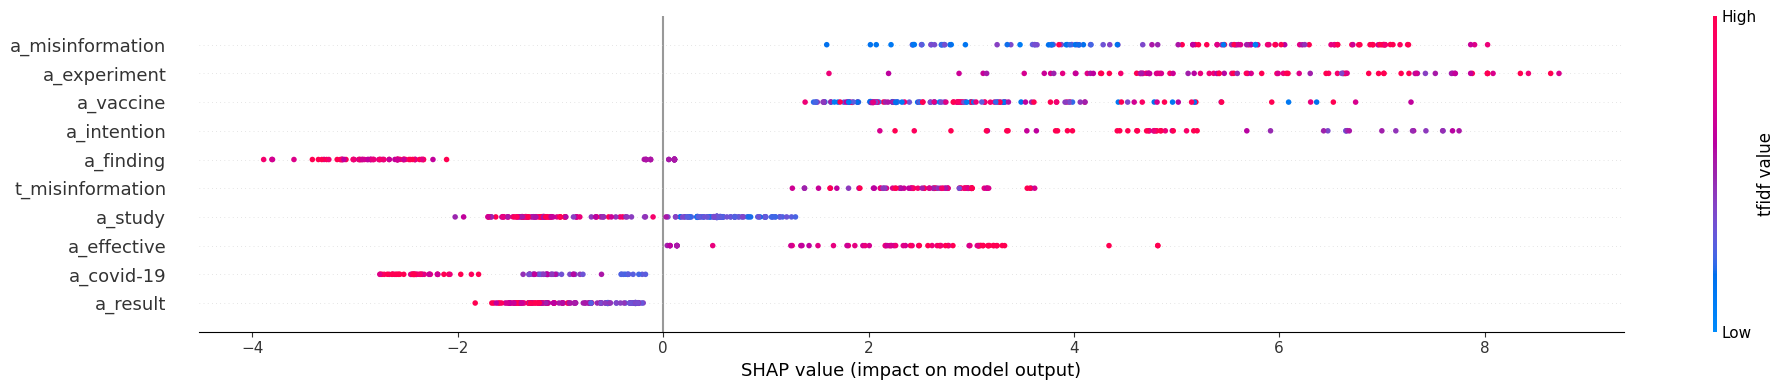

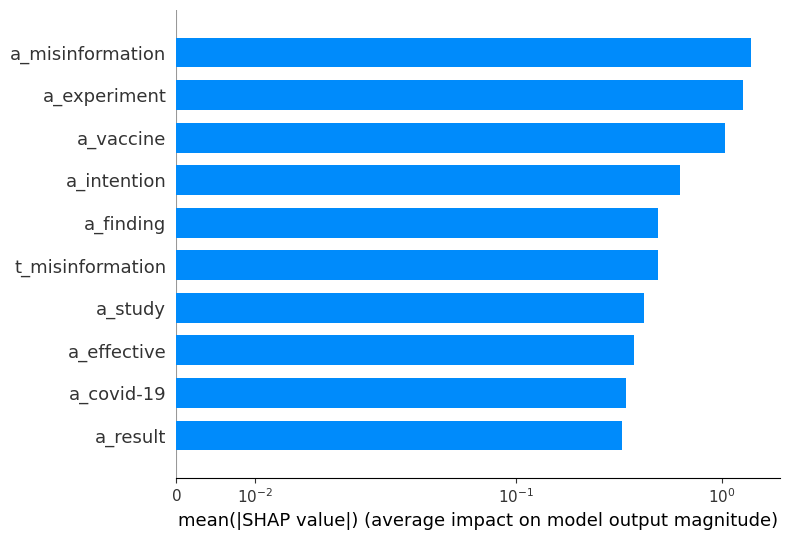

In [9]:
# EXLPAIN THE MODEL

from eppi_text_classification.shap_plotter import ShapPlotter

shap_plotter = ShapPlotter(model, X_test, feature_names)

# Maybe think about garbage collection and speak to James to see how he is actually doing it.
dotplot = shap_plotter.dot_plot(num_display=10)
dotplot.show()
dotplot = shap_plotter.dot_plot(num_display=10, log_scale=False)
dotplot.show()
barchart = shap_plotter.bar_chart()
barchart.show()

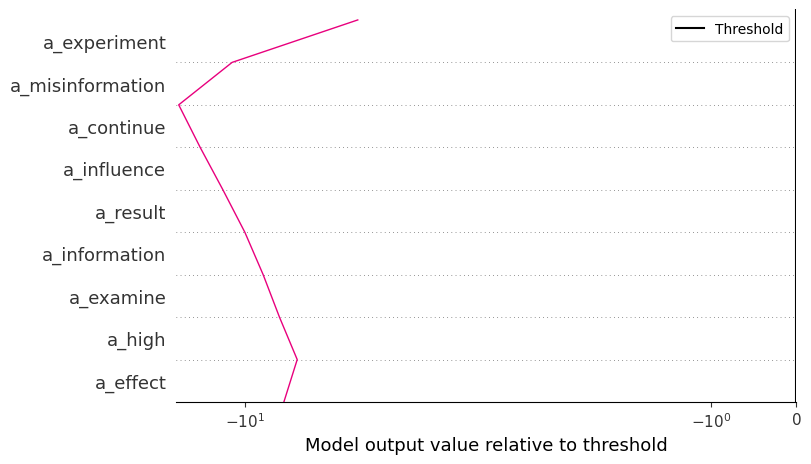

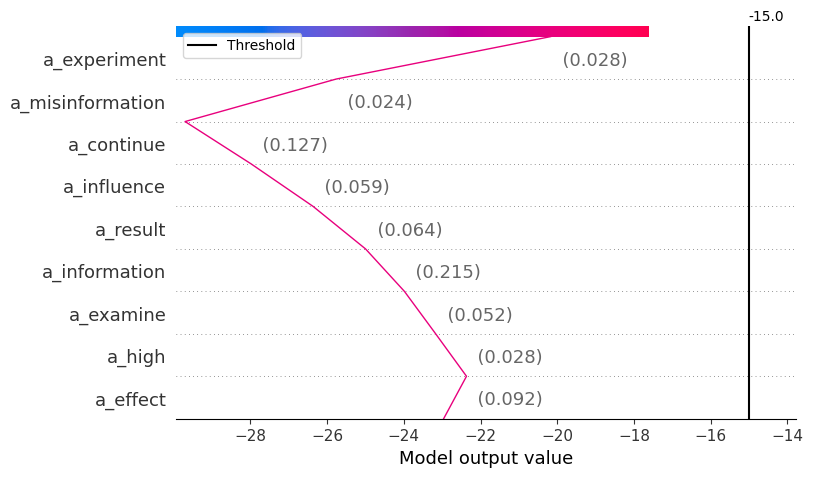

In [10]:
# MAKE THE DECISION PLOTS

shap_plotter = ShapPlotter(model, X_test[0:10], feature_names)


decision_plot = shap_plotter.single_decision_plot(
    threshold=threshold, num_display=10, log_scale=True, index=0
)
decision_plot.show()

decision_plot = shap_plotter.single_decision_plot(
    threshold=threshold, num_display=10, log_scale=False, index=0
)
decision_plot.show()

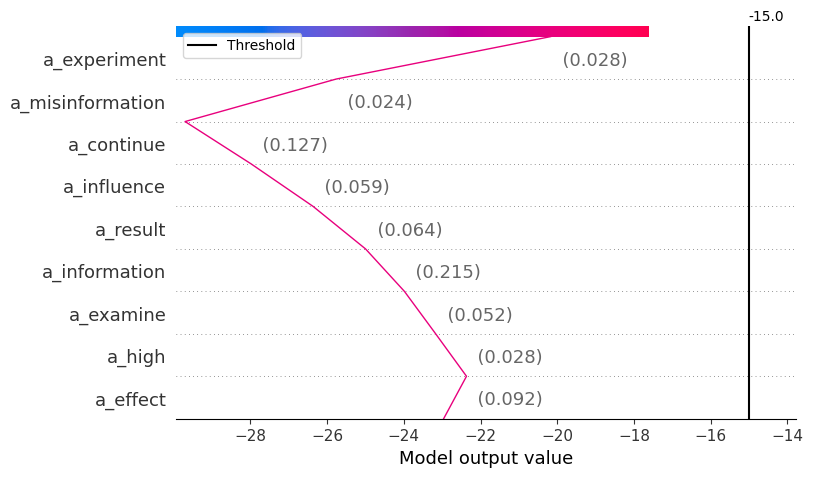

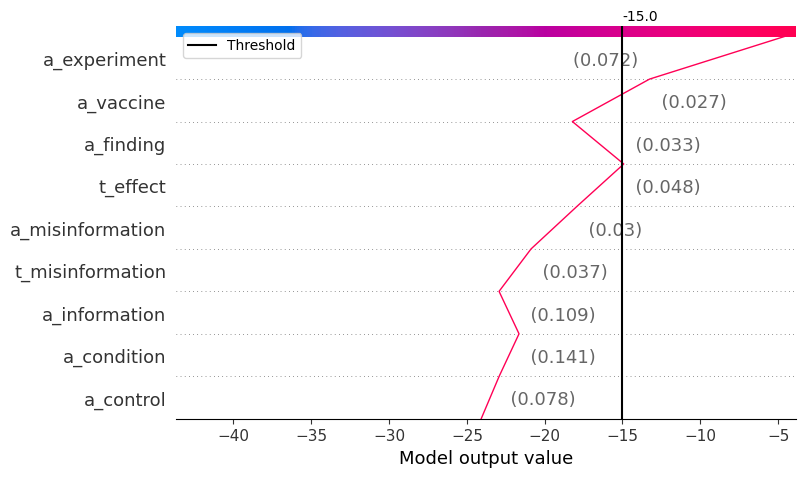

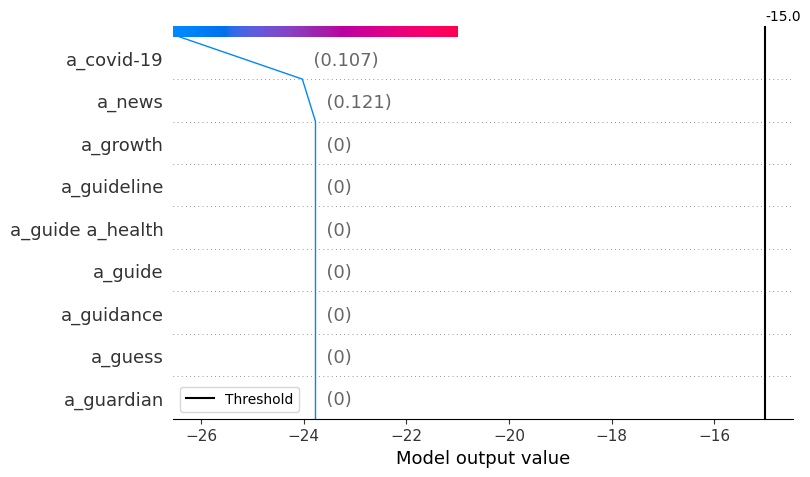

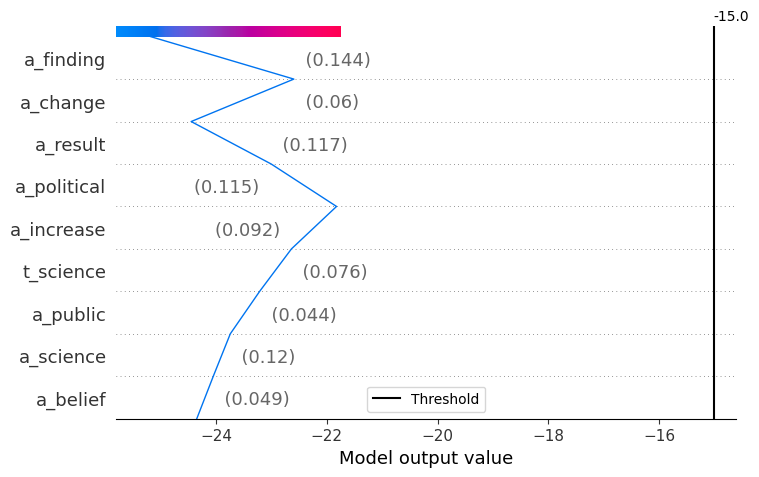

In [11]:
decision_plot = shap_plotter.single_decision_plot(
    threshold=threshold, index=0, num_display=10, log_scale=False
)
decision_plot.show()
decision_plot = shap_plotter.single_decision_plot(
    threshold=threshold, index=1, num_display=10, log_scale=False
)
decision_plot.show()
decision_plot = shap_plotter.single_decision_plot(
    threshold=threshold, index=2, num_display=10, log_scale=False
)
decision_plot.show()
decision_plot = shap_plotter.single_decision_plot(
    threshold=threshold, index=3, num_display=10, log_scale=False
)
decision_plot.show()